<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Complaints-Word-Frequency" data-toc-modified-id="Complaints-Word-Frequency-1">Complaints Word Frequency</a></span></li><li><span><a href="#Complaints-Word-Pairs" data-toc-modified-id="Complaints-Word-Pairs-2">Complaints Word Pairs</a></span></li></ul></div>

In [132]:
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import numpy as np
import os
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from tqdm.auto import tqdm
from wordcloud import WordCloud

After running our fetch_data function located in src the data from the the City of San Francisco's API has been downloaded to our data subdirectory.

In [133]:
# sys.path.append('../')
#load data into a Panda's dataframe
working_dir = os.getcwd()
data_path = os.path.dirname(working_dir) + '/data/'
df = pd.read_csv(data_path + 'raw_data.csv', usecols=['complaint_description', 'assigned_division'])

In [134]:
df.head()

,complaint_description,assigned_division
0,Date last observed: 29-jun-20; time last ob...,Housing Inspection Services
1,Unpermitted interior framing at 3rd level atti...,Electrical Inspection Division
2,Elevator (in the parking area )to condos is in...,Housing Inspection Services
3,Complainant is concerned about the lenght of t...,Building Inspection Division
4,Date last observed: 06-jan-21; time last ob...,Building Inspection Division


In [135]:
#view the shape of our dataset
df.shape

(267651, 2)

In [136]:
df.duplicated().sum()

83971

In [137]:
#drop duplicates
df.drop_duplicates(inplace = True)

In [139]:
print("Duplicated: ", df.duplicated().sum())
print("Shape: ", df.shape)

Duplicated:  0
Shape:  (183680, 2)


In [71]:
#ensure datatypes are correct
df.dtypes

complaint_description    object
assigned_division        object
dtype: object

In [140]:
#determine how many complaints there are for each category
df.assigned_division.value_counts()

Housing Inspection Services       86794
Building Inspection Division      63268
Plumbing Inspection Division      16242
Code Enforcement Section          10681
Electrical Inspection Division     5516
Disabled Access Division           1111
Help Desk / Technical Services       32
Department of Bldg Inspection        11
Other/Outside Agency                  9
Department of City Planning           4
Central Permit Bureau                 1
Seismic Safety Section                1
Major Plan Check Division             1
Department of Public Health           1
Name: assigned_division, dtype: int64

We will remove the categories that don't have at least 1000 complaints.

In [141]:
df = df.groupby("assigned_division").filter(lambda x: len(x) > 1000)

In [142]:
#examine a sample of complaint descriptions
display(df.complaint_description.sample(10))

58014     Light sensors need to be checked.  no lights i...
75124             Cracks in ceiling; plaster falling apart.
155998                  Pa#201102170472 has been suspended.
250295    Reported as: 2370 mission st - obsolete sign p...
188683    Unsafe lead paint work - no containment, no re...
257929    Date last observed: 19-dec-18;    time last ob...
84633           In basement, illegal kitchen and all rooms.
15913     Date last observed: 27-jan-18;    time last ob...
263998                                 Front dr. lock, sink
26714     General disrepair storage of flamable goods in...
Name: complaint_description, dtype: object

In [143]:
#check for null values
df.isna().sum()

complaint_description    5
assigned_division        0
dtype: int64

In [144]:
#drop any rows that contain null values
df.dropna(inplace = True)

In [145]:
#find the length of the longest complaint
df["complaint_description"].str.len().max()

1000

A histogram shows us that most complaints are around 40 to 80 words long, with a steep decline after 100 words. 
The distribution is cleary positively skewed and we also can confirm that complaints are getting cut off at 1000 characters in length, which we saw in the code before this. 

Mean complaint length:  148.274924158665
Min complaint length:  1
Max complaint length:  1000


Text(0, 0.5, 'Count')

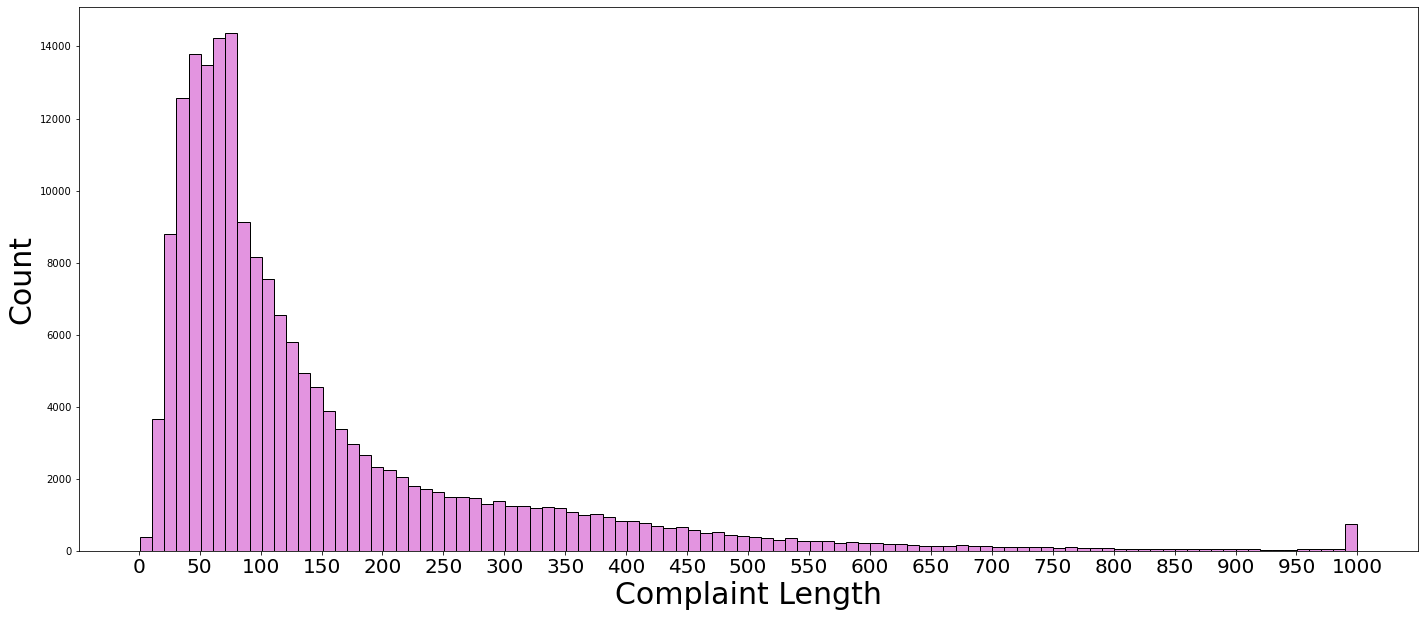

In [146]:
sample = df.copy()
sample['complaint_length'] = sample['complaint_description'].apply(len)
print("Mean complaint length: ", sample['complaint_length'].mean())
print("Min complaint length: ", sample['complaint_length'].min())
print("Max complaint length: ", sample['complaint_length'].max())

#plot a histogram of the complaint lengths
fig, ax = plt.subplots(figsize=(24,10))
ax = sns.histplot(data = sample, x='complaint_length', bins = 100, color = "orchid")
xticks = plt.xticks(np.arange(0, 1001, 50.0))
ax.tick_params(axis='x', labelsize=20)
ax.set_xlabel('Complaint Length', fontsize = 30)
ax.set_ylabel('Count', fontsize = 30)



In [147]:
routine_df = df[df['complaint_description'].str.contains("routine inspection")]

In [148]:
routine_df.assigned_division.value_counts()

Housing Inspection Services     833
Building Inspection Division      4
Code Enforcement Section          3
Plumbing Inspection Division      2
Name: assigned_division, dtype: int64

<h3>Complaints Word Frequency</h3>

(-0.5, 2399.5, 999.5, -0.5)

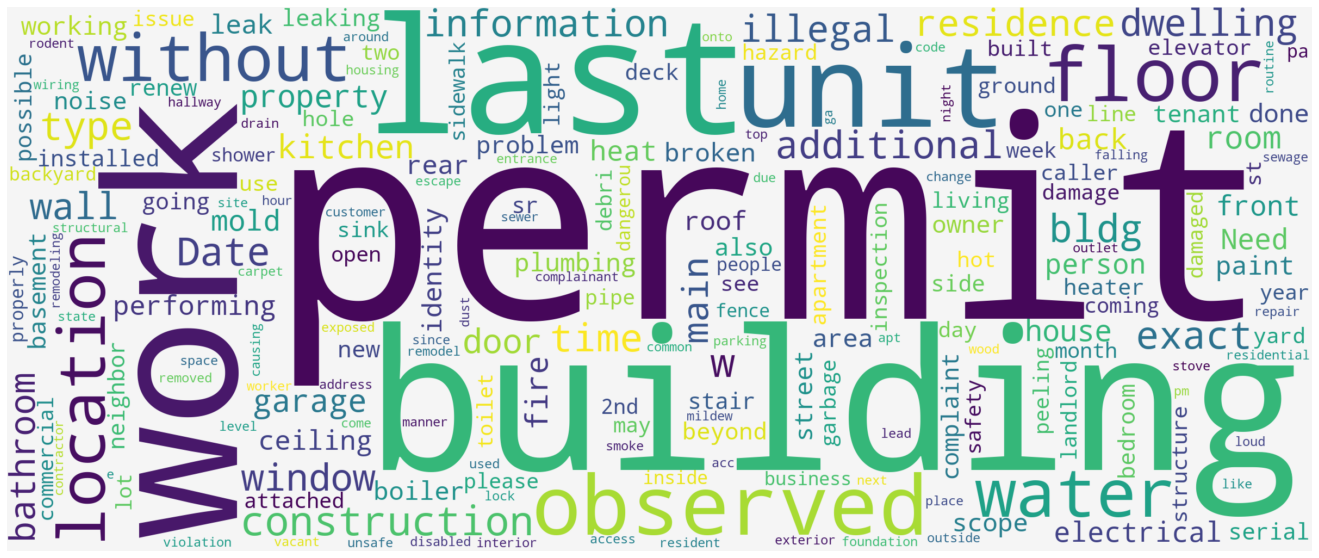

In [149]:
text = " ".join(complaint for complaint in df.complaint_description)
stop_words = stopwords.words('english')
wordcloud = WordCloud(stopwords=stop_words, background_color="whitesmoke",
                     collocations = False, width=2400, height=1000).generate(text)

fig, ax = plt.subplots(figsize=(24,10))
ax = plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")


<h3>Complaints Word Pairs</h3>

(-0.5, 2399.5, 999.5, -0.5)

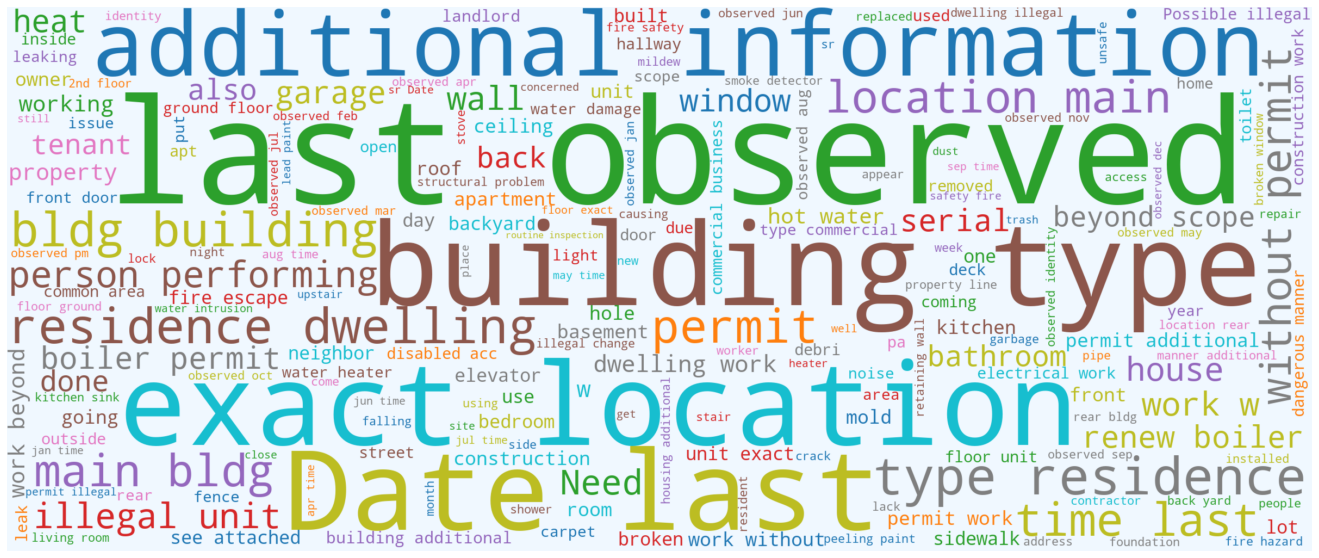

In [150]:
text = " ".join(complaint for complaint in df.complaint_description)
stop_words = stopwords.words('english')
wordcloud = WordCloud(stopwords=stop_words, background_color="aliceblue",
                     colormap = "tab10", width=2400, height=1000).generate(text)

fig, ax = plt.subplots(figsize=(24,10))
ax = plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

Finally we will save the preprocessed data in our /data subdirectory.
In the clean_data notebook we will create stemmed and lemmatized versions of 
the data using our clean_data module. Then we will tokenize the data using Tensorflow's tokenizer. 

In [151]:
#finally we save the preprocessed data to our data subdirectory 
#next we will stem or lemmatize the text before tokenizing it via Tensorflow
preprocessed = df.copy()
preprocessed.to_csv(data_path + '/preprocessed.csv',index = False)